In [1]:
#first import dependencies, mainly jax and numpyro
import time

#we change the config to use 
from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import numpy as np
import arviz as az

from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)
import pandas as pd
#read the data, please change to your data directory
data = pd.read_pickle('/home/dkn16/data.pkl')
FGnopol = data.beam.foregrounds.all_nopol
FGpol = data.beam.foregrounds.pleak
HI = data.beam.HI
noise = data.beam.noise
freqs = data.freqs

In [2]:
# read and resize our data
def get_data(dim,pol=False,x0=0,y0=0,freqs = 285,superpixel = None,selected = None):
    #dim,freqs: the datasize is (dim,dim,freqs)
    #pol(bool): if True, include the polarization leakage data
    #x0,y0: starting coordinates. e.g. pixels within x0:x0+dim will be included in the data.
    #superpixel: if larger than one, reshape the data to be (x_withinsp,y_withinsp,x_sp,y_sp,freq). In this case, data[0][0] is all pixels within superpixel (0,0)
    #selected: indexes to select several channels.
    
    #foreground
    if pol:
        sky = jnp.array(FGnopol+FGpol)[x0:x0+dim,y0:y0+dim,0:freqs].astype(jnp.float64)
    else:
        sky = jnp.array(FGnopol)[x0:x0+dim,y0:y0+dim,0:freqs].astype(jnp.float64)
    
    #HI signal
    cosmos = jnp.array(HI+noise)[x0:x0+dim,y0:y0+dim,0:freqs].astype(jnp.float64)
    
    #substract mean to 
    sky = sky - jnp.mean(sky,axis=(0,1))
    cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
    
    sky=sky.reshape((dim*dim,freqs))/1000
    cosmos=cosmos.reshape((dim*dim,freqs))/1000
    
    X = jnp.linspace(0., 1., sky.shape[1]).astype(jnp.float64)
    
    Y = sky+cosmos


    if superpixel is not None:
        Y = Y.reshape((dim,dim,freqs))
        Y = Y.reshape((int(dim/superpixel),superpixel,int(dim/superpixel),superpixel,freqs)).transpose((0,2,1,3,4))
        Y = Y.reshape((int(int(dim/superpixel)**2),-1,freqs)).transpose((1,0,2))

    
    if selected is not None:
        X = X[selected]
        Y = Y[...,selected]

    return X, Y

In [3]:
# RBF kernel for fg, exponential kernel for HI, and a diagonal noise kernel
def kernel(X, Z, var, length,var_HI,length_HI, noise, jitter=1.0e-16,is_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    deltaHI = jnp.abs((X[:, None] - Z) / length_HI)
    
    k_fg = var * jnp.exp(-0.5 * deltaXsq)
    k_HI = 1.0e-9*var_HI * jnp.exp(-0.5 * deltaHI)
    #k = var * jnp.exp(-0.5 * deltaXsq)
    if is_noise:
        k_HI += (noise*noise*1.0e-14 + jitter) * jnp.eye(X.shape[0])
        k_fg += k_HI
    return k_fg

# RBF kernel for fg, another RBF kernel for pol, exponential kernel for HI, and a diagonal noise kernel
def kernel_pol(X, Z, var, length,var_pol,length_pol,var_HI,length_HI, noise, jitter=1.0e-16,is_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    deltapol = jnp.power((X[:, None] - Z) / length_pol, 2.0)
    deltaHI = jnp.abs((X[:, None] - Z) *100/ length_HI)
    
    k_fg = 1.0e-2*var * jnp.exp(-0.5 * deltaXsq)
    k_pol = 1.0e-6*var_pol * jnp.exp(-0.5 * deltapol)
    k_HI = 1.0e-9*var_HI * jnp.exp(-0.5 * deltaHI)
    #k = var * jnp.exp(-0.5 * deltaXsq)
    if is_noise:
        k_HI += (noise*noise*1.0e-14 + jitter) * jnp.eye(X.shape[0])
        k_fg += k_HI
    return k_fg + k_pol

def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var_fg = numpyro.sample("kernel_var", dist.LogNormal(0,4))
    length_fg = numpyro.sample("kernel_length", dist.InverseGamma(2,1))
    
    noise = numpyro.sample("kernel_noise", dist.HalfNormal(1))
    
    var_HI = numpyro.sample("kernel_varHI", dist.HalfNormal(1))
    length_HI = numpyro.sample("kernel_lengthHI", dist.HalfNormal(2))
    
    var_pol = numpyro.sample("kernel_varpol", dist.LogNormal(0,4))
    length_pol = numpyro.sample("kernel_lengthpol", dist.InverseGamma(5,1))

    # compute kernel
    k = kernel_pol(X, X, var_fg, length_fg,var_pol,length_pol,var_HI,length_HI, noise)

    # calculating likelihood of Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        obs=Y, #by giving this obs numpyro will calculate the likelihood of it
    )


# helper function for doing hmc inference
def run_inference(model,init_strategy, rng_key, X, Y):
    start = time.time()
    # demonstrate how to use different HMC initialization strategies
    if init_strategy == "value":
        init_strategy = init_to_value(
            values={"kernel_var": 1.0, "kernel_noise": 0.05, "kernel_length": 0.5}
        )
    elif init_strategy == "median":
        init_strategy = init_to_median(num_samples=10)
    elif init_strategy == "feasible":
        init_strategy = init_to_feasible()
    elif init_strategy == "sample":
        init_strategy = init_to_sample()
    elif init_strategy == "uniform":
        init_strategy = init_to_uniform(radius=1)

    kernel = NUTS(
        model, 
        init_strategy=init_strategy,
        target_accept_prob=0.8,
        max_tree_depth=8)
    
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=1000,
        num_chains=1,
        thinning=1,
        progress_bar= True,
    )

    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples(),mcmc


# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
def predict(X, Y, X_test, var, length,var_pol, length_pol,var_HI, length_HI, noise):
    # compute kernels  K_fg
    k_pp = kernel_pol(X_test, X_test, var, length,var_pol, length_pol,var_HI, length_HI, noise,is_noise=False)

    #K_fg+k_HI
    k_XX = kernel_pol(X, X, var, length,var_pol, length_pol,var_HI, length_HI, noise,is_noise=True)

    #(K_fg+K_HI)^-1
    K_xx_inv = jnp.linalg.inv(k_XX)
    
    #E(d_fg|d_obs)
    mean = jnp.matmul(k_pp, jnp.matmul(K_xx_inv, Y.T)).T
    return mean




def main(selected = None):
    #get data
    X, Y = get_data(pol=True,dim=256,x0=0,y0=0,freqs=256,selected=selected)
    # do inference
    rng_key, rng_key_predict = random.split(random.PRNGKey(42))
    samples,mcmc = run_inference(model, "median", rng_key, X, Y)
    return samples,mcmc

   
def predict_fg(samples,thinning,selected = None):
    X, Y = get_data(pol=True,dim=256,x0=0,y0=0,freqs=256,selected = selected)
    iters = samples["kernel_var"].shape[0]
    batch = int(iters/thinning)
    rng_key, rng_key_predict = random.split(random.PRNGKey(42))
    # do prediction
    vmap_args = (
        random.split(rng_key_predict, batch),
        samples["kernel_var"][::thinning],
        samples["kernel_length"][::thinning],
        samples["kernel_varpol"][::thinning],
        samples["kernel_lengthpol"][::thinning],
        samples["kernel_varHI"][::thinning],
        samples["kernel_lengthHI"][::thinning],
        samples["kernel_noise"][::thinning],
    )

    #using vmap to do predictions in batch
    means = vmap(
        lambda rng_key, var, length,var_pol, length_pol,var_HI, length_HI, noise: predict(
            rng_key, X, Y, X, var, length,var_pol, length_pol,var_HI, length_HI, noise
        )
    )(*vmap_args)

    mean_prediction = np.mean(means, axis=0)
    percentiles = np.percentile(means, [5.0, 95.0], axis=0)
    
    return X,Y,mean_prediction,percentiles,samples
    # plt.savefig("gp_plot.pdf")

In [4]:
numpyro.set_platform('gpu')
#selected = np.concatenate([np.arange(64),np.arange(64)+96,np.arange(64)+192])
#selected = np.concatenate([np.arange(64),np.arange(32)+128,np.arange(32)+224])
selected = None
numpyro.set_host_device_count(1)
samples,mcmc = main(selected = selected)

sample: 100%|█| 2000/2000 [04:47<00:00,  6.96it/s, 23 steps of size 7.40e-02. ac



                        mean       std    median      5.0%     95.0%     n_eff     r_hat
     kernel_length      1.80      0.00      1.80      1.79      1.80    539.67      1.00
   kernel_lengthHI      1.69      0.01      1.69      1.68      1.70    541.90      1.00
  kernel_lengthpol      0.22      0.00      0.22      0.22      0.22    529.17      1.00
      kernel_noise      0.11      0.08      0.09      0.00      0.21    528.34      1.00
        kernel_var      6.12      0.03      6.12      6.07      6.18    486.29      1.00
      kernel_varHI      1.56      0.01      1.56      1.55      1.57    551.74      1.00
     kernel_varpol      0.45      0.00      0.45      0.44      0.46    516.94      1.00

Number of divergences: 0

MCMC elapsed time: 295.35768866539


In [8]:
#calculate cross validation score with arviz
import arviz as az
idata = az.from_numpyro(mcmc)
loo_orig = az.loo(idata, pointwise=True)
loo_orig

Computed from 1000 posterior samples and 65536 observations log-likelihood matrix.

         Estimate       SE
elpd_loo 157337711.12  7972.10
p_loo       36.22        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     65536  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

In [10]:
#idata = az.from_numpyro(mcmc)
idata = az.from_numpyro(mcmc)
loo_orig = az.loo(idata, pointwise=True)
loo_orig

Computed from 1000 posterior samples and 65536 observations log-likelihood matrix.

         Estimate       SE
elpd_loo 77450368.49  4895.66
p_loo       27.12        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     65536  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

In [5]:
# do the prediction
X,Y,mean_prediction,percentiles,samples = predict_fg(samples,25,selected = selected)

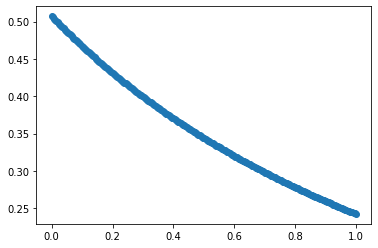

In [6]:
#plot obs data and our separated foreground
plt.fill_between(X, percentiles[0, 0,:], percentiles[1, 0,:], color="lightblue")
plt.scatter(X,Y[0])
plt.plot(X,mean_prediction[0])

In [7]:
#collect the true HI data
x0 = 0
y0 = 0
dim = 256
freqs = 256
cosmos = HI[x0:x0+dim,y0:y0+dim,0:freqs]
cosmos = cosmos[:,:,selected]  
cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
cosmos = cosmos.reshape(dim*dim,-1)

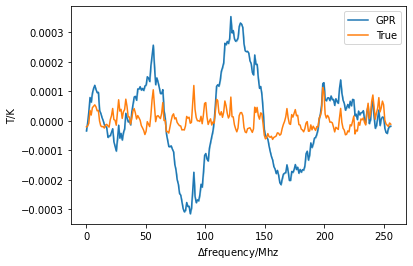

In [15]:
#plot recovered HI at some pixel
i=250
plt.plot(X*freqs,Y[i]-mean_prediction[i])
plt.plot(X*freqs,cosmos[i]/1000)
plt.fill_between(X*freqs,Y[i]-percentiles[0, i,:], Y[i]-percentiles[1, i,:], color="lightblue")
plt.xlabel(r'$\Delta$frequency/Mhz')
plt.ylabel(r'T/K')
plt.legend(['GPR','True'])
#np.save('/scratch/dkn16/result_CP_nopol.npy',(Y-mean_prediction).reshape((dim,dim,-1)))

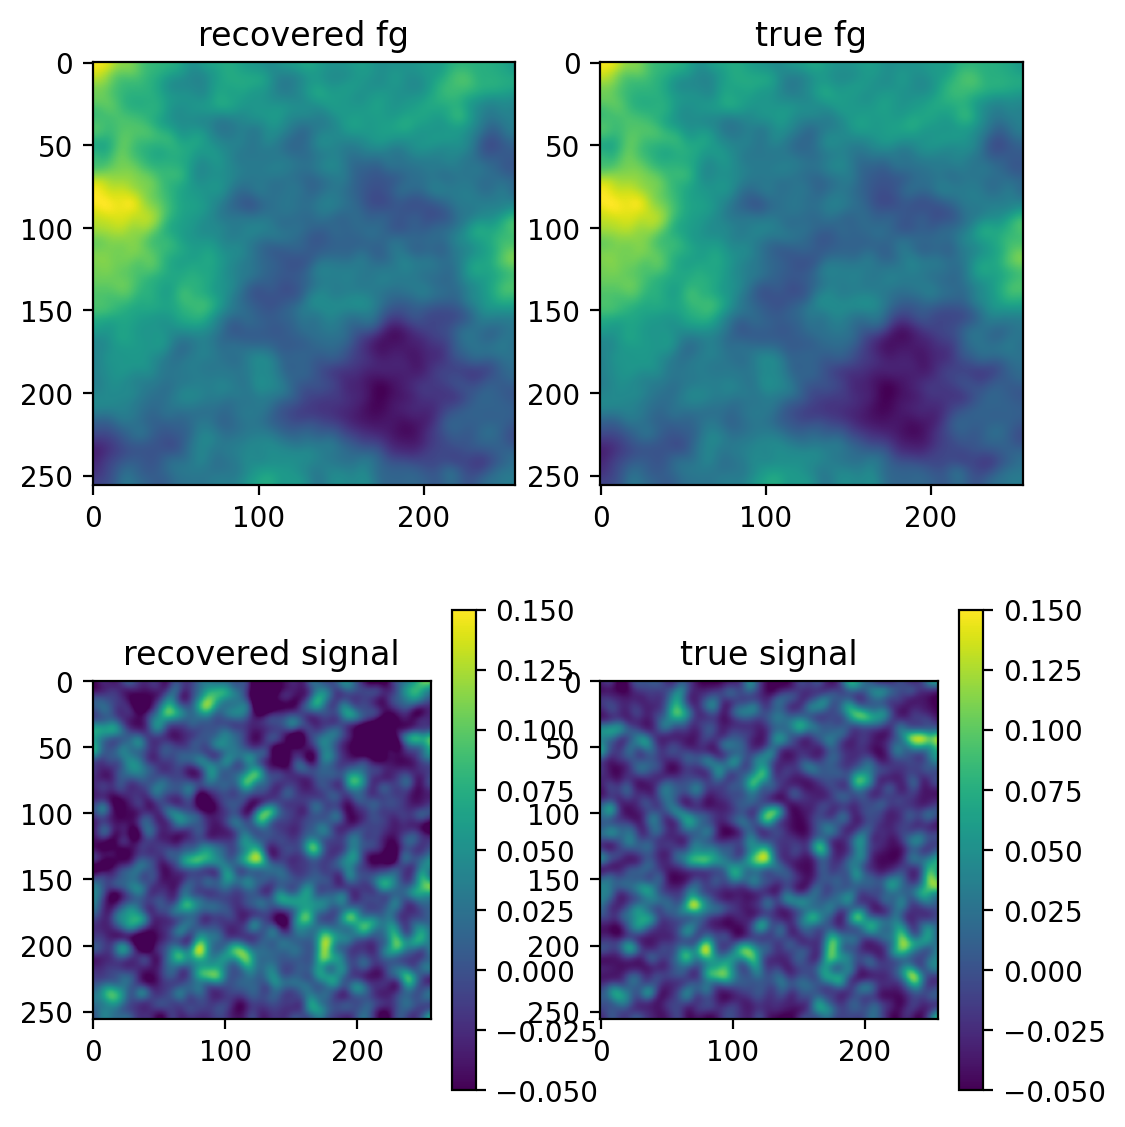

In [16]:
# plot images at i-th frequency slice
i=8
plt.figure(figsize=(6,7),dpi=200)
plt.subplot(2,2,1)
plt.imshow(mean_prediction[:,i].reshape(dim,dim))
plt.title('recovered fg')
plt.subplot(2,2,2)
plt.imshow(Y[:,i].reshape(dim,dim))
plt.title('true fg')
plt.subplot(2,2,3)
plt.imshow((Y[:,i]-mean_prediction[:,i]).reshape(dim,dim)*1000,vmax=0.15,vmin=-0.05)
plt.title('recovered signal')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(cosmos[:,i].reshape(dim,dim),vmax=0.15,vmin=-0.05)
plt.title('true signal')
plt.colorbar()

In [12]:
# Here we drawing some examples for RBF kernel and exponential kernel

def RBFkernel(X, Z, var, length,jitter = 1e-14):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    
    k_fg = var * jnp.exp(-0.5 * deltaXsq)
    return k_fg+jitter*jnp.eye(X.shape[0])

def EXPkernel(X, Z,var_HI,length_HI):
    deltaHI = jnp.abs((X[:, None] - Z) / length_HI)
    k_HI = var_HI * jnp.exp(-0.5* deltaHI)
    
    return k_HI

X = np.arange(0,1,0.01)
k1 = RBFkernel(X, X,  1.0, 0.5)
k2 = RBFkernel(X, X,  1.0, 0.05)
k3 = EXPkernel(X, X,  1.0, 0.5)
k4 = EXPkernel(X, X,  1.0, 0.01)
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
samp = numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros((2,2,X.shape[0])), covariance_matrix=[[k1,k2],[k3,k4]]),
        #obs=Y,
        rng_key= rng_key,sample_shape=(20,)
    )


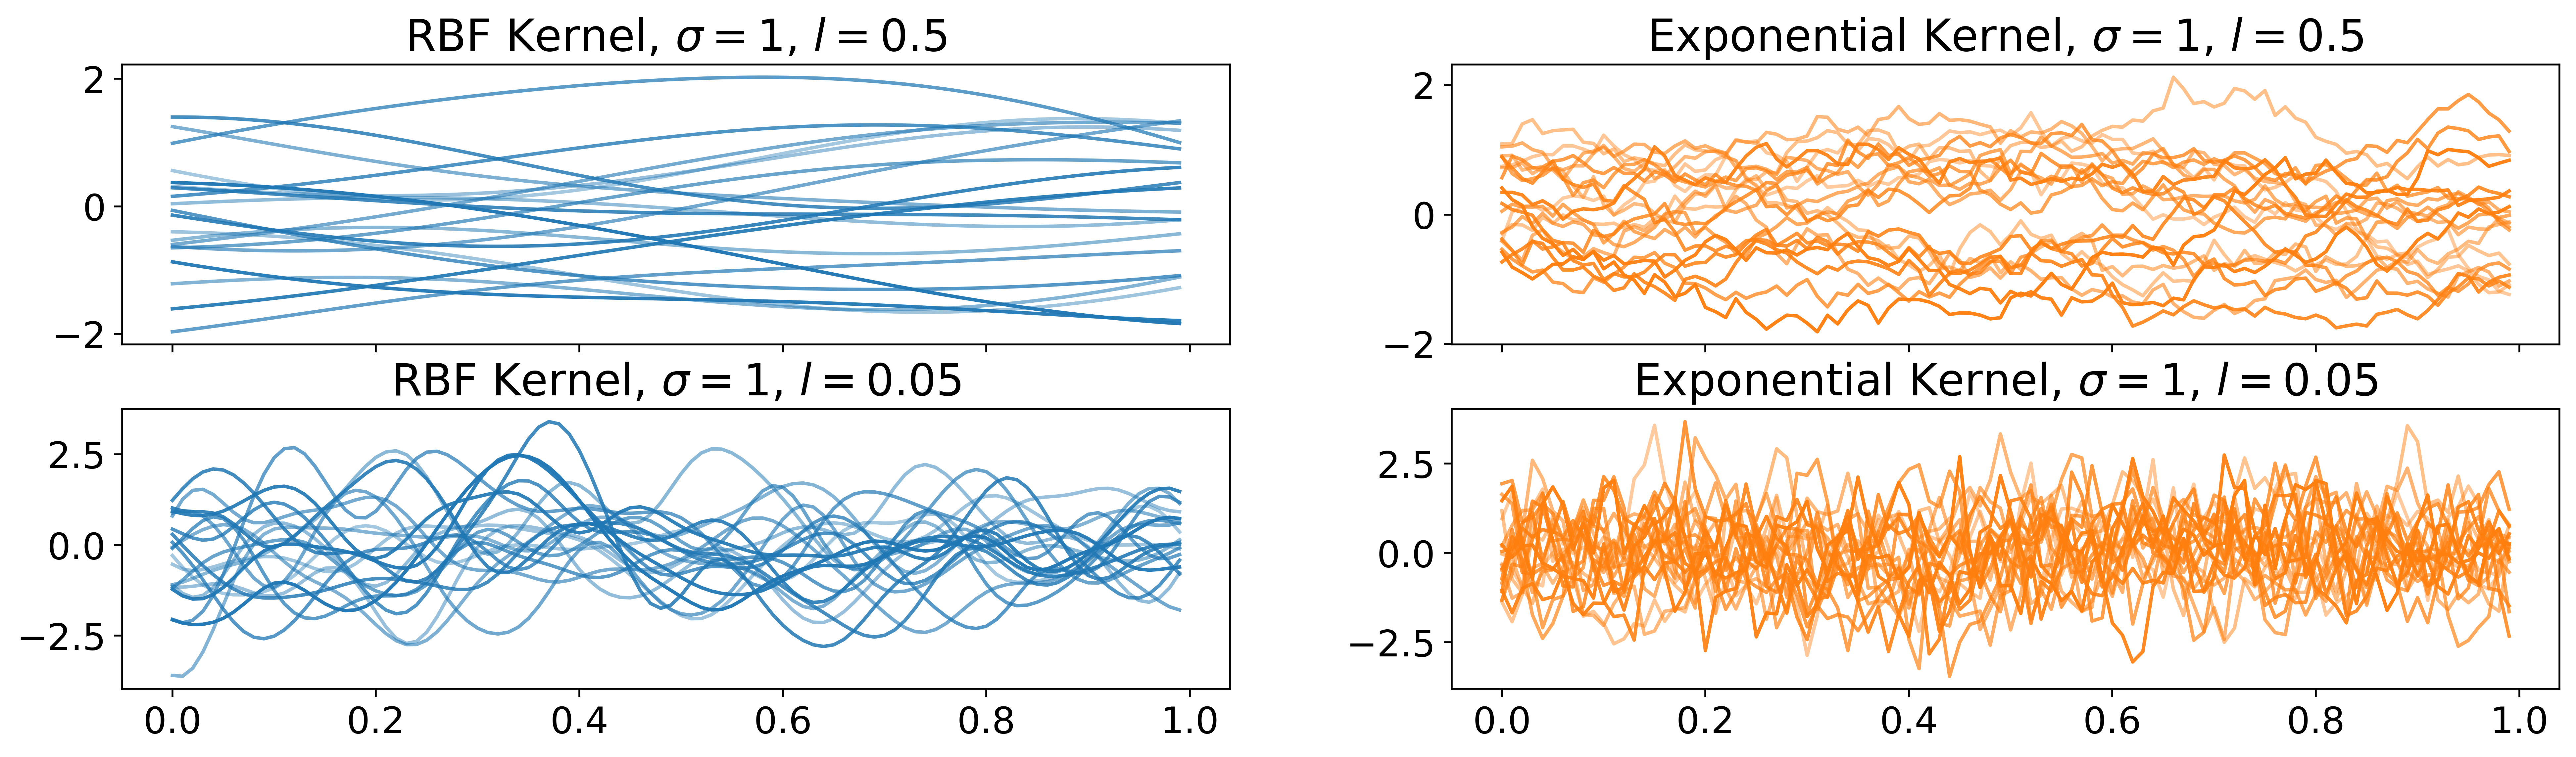

In [20]:
font = {"size": 16,}
axislabelfontsize = "x-large"
plt.rc("font", **font)
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(nrows=2, ncols=2, sharex='col', 
                                                       figsize=(19,5),dpi=500)
fig.subplots_adjust(hspace=0.23, wspace=0.2)


for i in range(20):
    ax1.plot(X,samp[i][0][0],c='tab:blue',alpha = 0.03*i+0.4)
    ax2.plot(X,samp[i][0][1],c='tab:blue',alpha = 0.03*i+0.4)
    ax3.plot(X,samp[i][1][0],c='tab:orange',alpha = 0.03*i+0.4)
    ax4.plot(X,samp[i][1][1],c='tab:orange',alpha = 0.03*i+0.4)
    
ax1.set_title(r'RBF Kernel, $\sigma=1$, $l=0.5$')
ax2.set_title(r'RBF Kernel, $\sigma=1$, $l=0.05$')
ax3.set_title(r'Exponential Kernel, $\sigma=1$, $l=0.5$')
ax4.set_title(r'Exponential Kernel, $\sigma=1$, $l=0.05$')

plt.savefig('Samples.pdf',dpi=500,bbox_inches='tight')

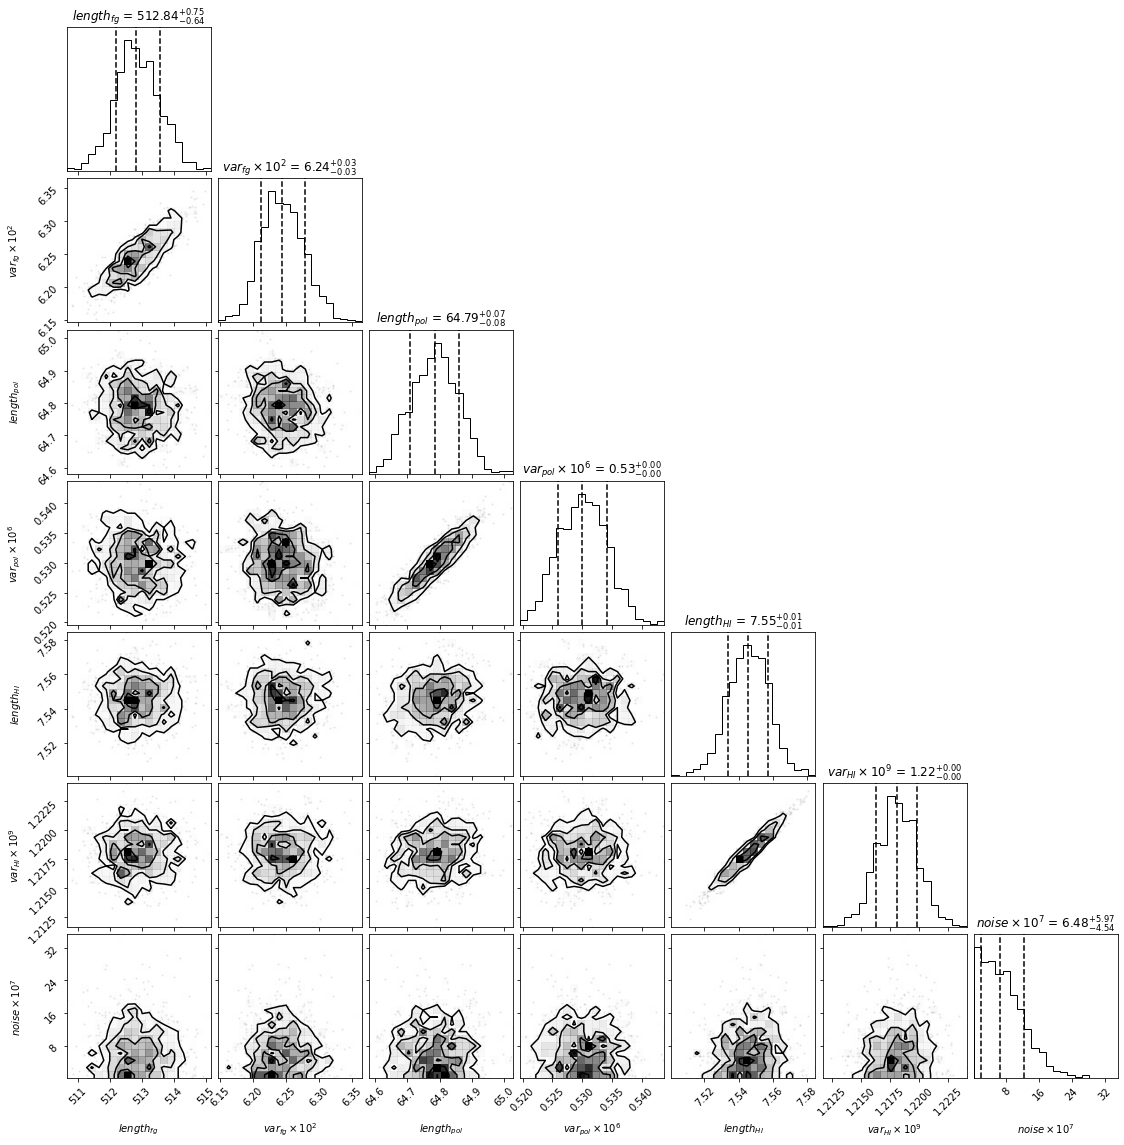

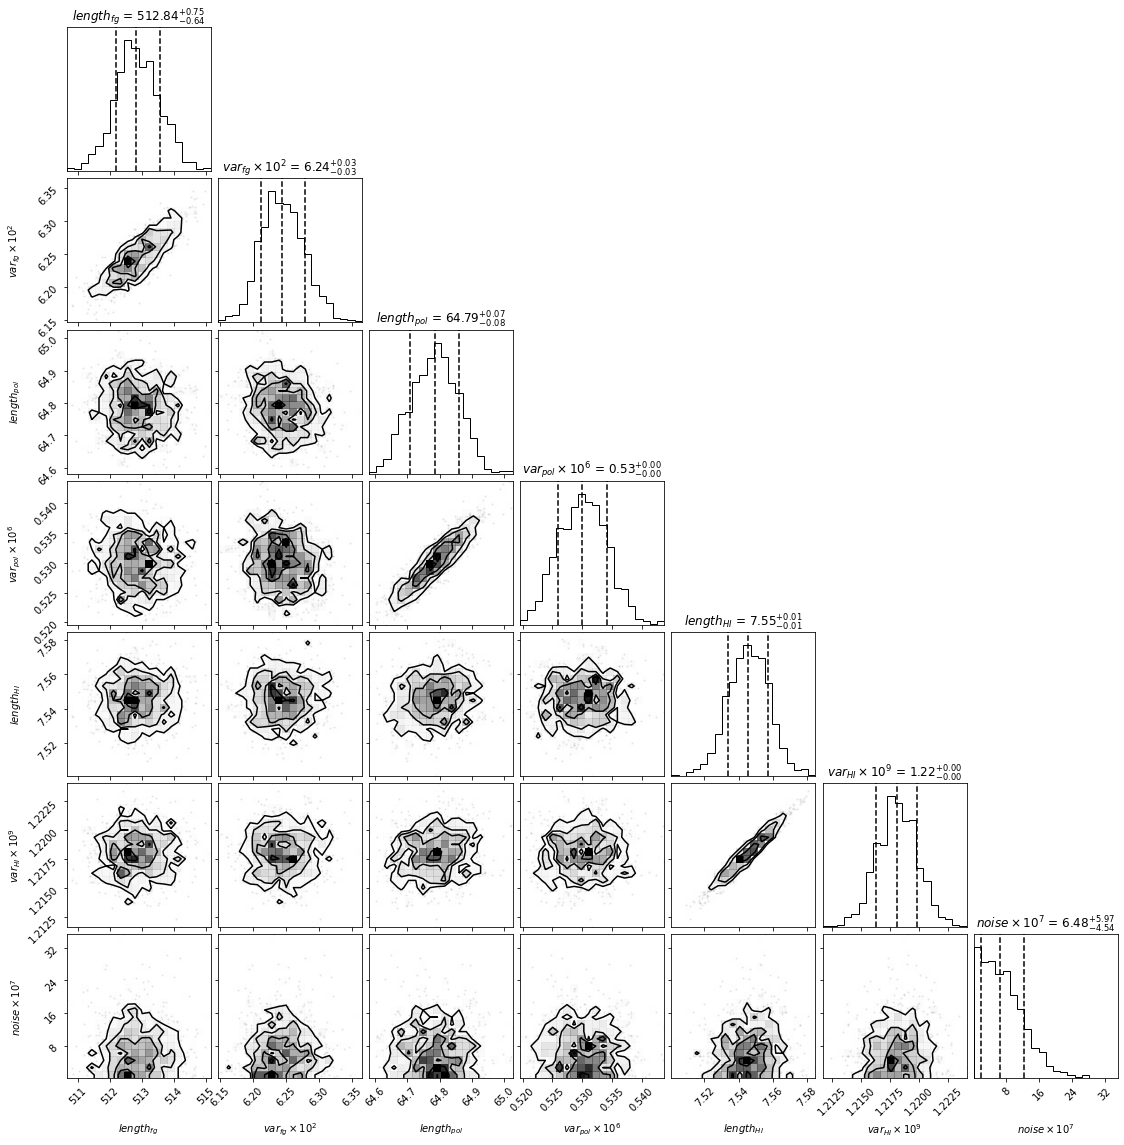

In [15]:
#we draw a corner plot to check if our results are converged.
import corner
data = np.vstack([samples['kernel_length']*285,samples['kernel_var'],samples['kernel_lengthpol']*285,samples['kernel_varpol'],samples['kernel_lengthHI']*2.85*2,samples['kernel_varHI'],samples['kernel_noise']*100]).T
corner.corner(data,labels=[
        r"$length_{fg}$",
        r"$var_{fg}\times 10^{2}$",
        r"$length_{pol}$",
        r"$var_{pol}\times 10^{6}$",
        r"$length_{HI}$",
        r"$var_{HI}\times 10^{9}$",
        r"$noise\times 10^{7}$",
    ],quantiles=[0.16, 0.5, 0.84],show_titles=True)

$ \mathrm{cov}\left[f_{\rm fg}|K,\sigma_\eta\right] = K_{\rm fg}-K_{\rm fg}\left(K_{\rm fg}+K_{\rm HI}+\sigma_\eta^2 I_N\right)^{-1}K_{\rm fg}$

In [ ]:
# calculating cov[f_{fg}] as is shown above, then sample from it as our bias
# however according to our test, the precisionn requiremennt is beyond fp64
# thus we use mpmath, slow but accurate
import mpmath
selected = None


def generate_kernel(X,  X_test, var, length,var_pol, length_pol,var_HI, length_HI, noise):
    #k_pp is fg kernel
    k_pp = kernel_pol(X_test, X_test, var, length,var_pol, length_pol,var_HI, length_HI, noise,is_noise=False)
    
    #k_XX is the fg + HI + noise kernel
    k_XX = kernel_pol(X, X, var, length,var_pol, length_pol,var_HI, length_HI, noise,is_noise=True)
    return k_pp,k_XX

def generate_K(k_pp,k_XX):
    #convert them to higher precision
    k_XX = mpmath.matrix(np.array(k_XX).astype(np.float64))
    k_pp = mpmath.matrix(np.array(k_pp).astype(np.float64))
    
    #do the inversion
    K_xx_inv = mpmath.inverse(k_XX)
    
    #do the calculation of cov
    K = k_pp - k_pp*(K_xx_inv*k_pp)
    
    #convert it back to numpy array
    K = np.array(K.tolist(),dtype= jnp.float64)
    return K

# generate random samples
def generate_samples(rng_key,K,X,Y,num_samples=40):
    samp = numpyro.sample(
            "Y",
            dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=K+1e-14*jnp.eye(X.shape[0])),# add a small diagnal matrix to avoid numerical issues
            rng_key= rng_key,sample_shape=(num_samples,Y.shape[0],Y.shape[1],)
        )
    return samp

def correct_bias(samples,dim=256,x0=0,y0=0,selected=None,superpixel = None):
    X, Y = get_data(pol=True,dim=dim,x0=x0,y0=y0,freqs=256,superpixel=superpixel,selected=selected)
    
    rng_key,next_key = random.split(random.PRNGKey(23))
    
    # do prediction
    vmap_args = [
            samples["kernel_var"],
            samples["kernel_length"],
            samples["kernel_varpol"],
            samples["kernel_lengthpol"],
            samples["kernel_varHI"],
            samples["kernel_lengthHI"],
            samples["kernel_noise"]
    ]
    
    #generate matrix for nex step
    k_pp,k_XX = generate_kernel( X, X, jnp.mean(vmap_args[0]), jnp.mean(vmap_args[1]),jnp.mean(vmap_args[2]), jnp.mean(vmap_args[3]),jnp.mean(vmap_args[4]), jnp.mean(vmap_args[5]), jnp.mean(vmap_args[6])
            )
    #calculating the cov matrix
    K = generate_K(k_pp,k_XX)
    
    #sample
    samp = generate_samples(rng_key,K,X,Y,40)
    
    return samp,K

In [ ]:
samp,K = correct_bias(samples)

In [ ]:
#draw some samples
X, Y = get_data(pol=True,dim=256,x0=0,y0=0,freqs=256,superpixel=superpixel,selected=selected)
for i in range(40):
    plt.plot(X,samp[i,i])